# Mac and Linux setup

Make sure to have enabled the environment set up for running `dimelo` analysis. See the readme for details. If you are running your jupyter notebook some way other than by the `jupyter notebook` command in the command line from within your activated `conda` environment, you may need to use `ipykernel` to connect this notebook appropriately to the environment with `dimelo` and `modkit` installed.

# Colab setup

If you are running in Google Colab, run the cell below. **You may need to run twice if e.g. the default package versions in your Colab instance need to change.** You should see the `pip` message `Successfully installed dimelo-1.0.0` before continuing.

If you're not on Colab, you can run this cell if you like but it will error out.

In [1]:
# Lets Colab access your Google drive
try:
    from google.colab import drive
except:
    print("""
You don't seem to be running on Google Colab so this cell is not going to be useful for you.
Make sure you are running you notebook in a conda environment set up as per README.md.
Once you have this notebook running in a correctly configured environment, proceed to the rest of the cells.
          """)
else:
    drive.mount('/content/drive')
    # Install condacolab to let us get the modkit dependency
    !pip install -q condacolab
    import condacolab
    condacolab.install()
    # Install modkit
    !conda install nanoporetech::modkit==0.2.4
    # Clone the repo, change the active path to be inside the repo, and install the package
    !rm -r dimelo
    !git clone -b modkit_parsing_main https://github.com/streetslab/dimelo
    import os
    os.chdir('dimelo')
    !pip install .



You don't seem to be running on Google Colab so this cell is not going to be useful for you.
Make sure you are running you notebook in a conda environment set up as per README.md.
Once you have this notebook running in a correctly configured environment, proceed to the rest of the cells.
          


# System and Versions Information

## Conda Environment

Run this cell to list the packages present in your conda environment

In [45]:
!conda list

# packages in environment at /Users/oberondixon-luinenburg/mambaforge/envs/dimelo_modkit_parsing:
#
# Name                    Version                   Build  Channel
appnope                   0.1.3                    pypi_0    pypi
asttokens                 2.4.1                    pypi_0    pypi
bzip2                     1.0.8                h93a5062_5    conda-forge
ca-certificates           2023.11.17           hf0a4a13_0    conda-forge
comm                      0.2.1                    pypi_0    pypi
contourpy                 1.2.0                    pypi_0    pypi
cycler                    0.12.1                   pypi_0    pypi
debugpy                   1.8.0                    pypi_0    pypi
decorator                 5.1.1                    pypi_0    pypi
dimelo                    1.0.0                     dev_0    <develop>
executing                 2.0.1                    pypi_0    pypi
fonttools                 4.47.2                   pypi_0    pypi
h5py                  

## System Information

Run this cell to list system information about your machine

In [2]:
import platform
print('System:',platform.system())
print('Release:',platform.release())
print('Version:',platform.version())
print('Processor:',platform.processor())

System: Darwin
Release: 21.6.0
Version: Darwin Kernel Version 21.6.0: Sat Jun 18 17:07:22 PDT 2022; root:xnu-8020.140.41~1/RELEASE_ARM64_T6000
Processor: arm


## Git Repo Version

Run this cell to capture the exact repo version you're running, in case we need to debug anything

In [3]:
!git -C . log -1 --format=%H

0cc3c4f67dca6882fcae41ef0059347ac56bd3ef


# Initialization

In [4]:
from pathlib import Path
from matplotlib import pyplot as plt

In [5]:
# Base input and output directories
test_data_dir = Path('./test/data')
output_dir = Path('./test/output')

output_dir.mkdir(exist_ok=True)

# Input files
ctcf_bam_file = test_data_dir / 'ctcf_demo.sorted.bam'
ctcf_guppy_bam_file = test_data_dir / 'winnowmap_guppy_merge_subset.updated.bam'
ctcf_target_regions = test_data_dir / 'ctcf_demo_peak.bed'
ctcf_off_target_regions = test_data_dir / 'ctcf_demo_not_peak.bed'

In [4]:
!wget https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/chm13.draft_v1.0.fasta.gz -O ./test/output/chm13.draft_v1.0.fasta.gz
!gunzip ./test/output/chm13.draft_v1.0.fasta.gz

--2024-02-05 10:26:27--  https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/chm13.draft_v1.0.fasta.gz
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.162.0, 52.92.193.232, 52.92.187.184, ...
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.162.0|:443... connected.


HTTP request sent, awaiting response... 200 OK
Length: 890102223 (849M) [binary/octet-stream]
Saving to: ‘./test/output/chm13.draft_v1.0.fasta.gz’

./test/output/chm13 100%[===================>] 848.87M  15.5MB/s    in 55s     

2024-02-05 10:27:22 (15.5 MB/s) - ‘./test/output/chm13.draft_v1.0.fasta.gz’ saved [890102223/890102223]

./test/output/chm13.draft_v1.0.fasta already exists -- do you wish to overwrite (y or n)? ^C


In [6]:
ref_genome_file = Path('./test/output/chm13.draft_v1.0.fasta')

# Basic Use Overview

For details on parameters and functionality breakdown, please read the README sections on **Basic Use**, especially **Parameters and what they mean**.

# Parsing

In [7]:
from dimelo import parse_bam

modkit found with expected version 0.2.4


The `try` statement in the following cell is expected to run into an exception thanks to input BAM format checking. Without a `try` statement, when the exception is raised it will terminate python execution because passing a bam file that doesn't meet the specifications will cause wasted compute time: `modkit` will find no valid base modifications and return all-zero data.

However, `modkit` also comes with two tools that can update bam files to meet spec.

## Pileup and Update Tags

In [8]:
try:
    pileup_file = parse_bam.pileup(
        input_file=ctcf_bam_file,
        output_name='ctcf_demo_pileup',
        ref_genome=ref_genome_file,
        output_directory=output_dir,
        regions=[ctcf_target_regions],
        motifs=['A,0','CG,0'],
        # thresh=190,
        window_size=1000,
        # cores=None,
        # cleanup=False
    )
    print('The code executed successfully.')
except Exception as e:
    print('This is expected to fail. Read the error message below:\n\n')
    print(e)

This is expected to fail. Read the error message below:


Base modification tags are out of spec (Mm and Ml instead of MM and ML). 

Consider using "modkit update-tags test/data/ctcf_demo.sorted.bam new_file.bam" in the command line with your conda environment active and then trying with the new file. For megalodon basecalling/modcalling, you may also need to pass "--mode ambiguous.
Be sure to index the resulting .bam file."


To fix this, follow the suggestion from the error and run `modkit update-tags`...

In [9]:
!modkit update-tags \
test/data/ctcf_demo.sorted.bam \
test/output/ctcf_demo.updated.bam \
--mode ambiguous

> done, 1024 records processed, 0 failed, 0 skipped                             


In [10]:
ctcf_bam_file_updated = output_dir / 'ctcf_demo.updated.bam'

...and reindex the resulting file.

In [11]:
import pysam

pysam.index(str(ctcf_bam_file_updated))

''

Finally, the updated .bam file can be parsed, both for pileup and read extraction:

In [12]:
pileup_file = parse_bam.pileup(
    input_file=ctcf_bam_file_updated,
    output_name='ctcf_demo_pileup_on_target',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    regions=[ctcf_target_regions,ctcf_off_target_regions],
    motifs=['A,0','CG,0'],
    thresh=190,
    window_size=1000,
    # cores=None,
    cleanup=False
)

No specified number of cores requested. 8 available on machine, allocating all.
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.


> parsed user-input threshold 0.74509805 for mod-code Y
> parsed user-input threshold 0.74509805 for mod-code Z
> parsed user-input threshold 0.74509805 for mod-code A
> parsed user-input threshold 0.74509805 for mod-code m
> parsed user-input threshold 0.74509805 for mod-code a
> parsing BED at test/output/ctcf_demo_pileup_on_target/regions.processed.bed
> processed 300 BED lines
> calculated chunk size: 12, interval size 100000, processing 1200000 positions concurrently
> Using filter threshold 0.74509805 for mod code Y.
> Using filter threshold 0.74509805 for mod code Z.
> Using filter threshold 0.74509805 for mod code A.
> Using filter threshold 0.74509805 for mod code m.
> Using filter threshold 0.74509805 for mod code a.
> Done, processed 123046 rows. Processed ~1012 reads and skipped zero reads.


In [13]:
# pileup_whole_file = parse_bam.pileup(
#     input_file=ctcf_bam_file_updated,
#     output_name='ctcf_demo_pileup_on_target',
#     ref_genome=ref_genome_file,
#     output_directory=output_dir,
#     basemods=['A,0','CG,0'],
#     thresh=190,
#     # cores=None,
#     # cleanup=False
# )

In [14]:
# guppy_pileup_chr1 = parse_bam.pileup(
#     input_file=ctcf_guppy_bam_file,
#     output_name='ctcf_demo_guppy_pileup',
#     ref_genome=ref_genome_file,
#     output_directory=output_dir,
#     regions='chr1:9000000-10000000',
#     motifs=['A,0','CG,0'],
#     thresh=190,
#     # cores=None,
#     # cleanup=False
# )
# megalodon_pileup_chr1 = parse_bam.pileup(
#     input_file=ctcf_bam_file_updated,
#     output_name='ctcf_demo_megalodon_pileup',
#     ref_genome=ref_genome_file,
#     output_directory=output_dir,
#     regions='chr1:9000000-10000000',
#     motifs=['A,0','CG,0'],
#     thresh=190,
#     # cores=None,
#     # cleanup=False
# )

## Extract

In [15]:
extract_file = parse_bam.extract(
    input_file=ctcf_bam_file_updated,
    output_name='ctcf_demo_extract',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    regions=[ctcf_target_regions,ctcf_off_target_regions],
    motifs=['A,0','CG,0'],
    thresh=190,
    window_size=1000,
    # cores=None,
    cleanup=False
)

No specified number of cores requested. 8 available on machine, allocating all.
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.
Extracting A,0 sites


> specifying include-only BED outputs only mapped sites
> parsing BED at test/output/ctcf_demo_extract/regions.processed.bed
> processed 300 BED lines
> found BAM index, processing reads in 100000 base pair chunks
> processed 963 reads, 1278404 rows, skipped ~0 reads, failed ~0 reads


Adding A,0 to test/output/ctcf_demo_extract/reads.combined_basemods.h5
963 reads found in test/output/ctcf_demo_extract/reads.A,0.txt
Extracting CG,0 sites


> specifying include-only BED outputs only mapped sites
> parsing BED at test/output/ctcf_demo_extract/regions.processed.bed
> processed 300 BED lines
> found BAM index, processing reads in 100000 base pair chunks
> processed 963 reads, 106327 rows, skipped ~0 reads, failed ~0 reads


Adding CG,0 to test/output/ctcf_demo_extract/reads.combined_basemods.h5
963 reads found in test/output/ctcf_demo_extract/reads.CG,0.txt
extending from 963 to 1926


# Plotting

## Plot Enrichment Profile

In [16]:
from dimelo import plot_enrichment_profile

<Axes: xlabel='pos', ylabel='fraction modified bases'>

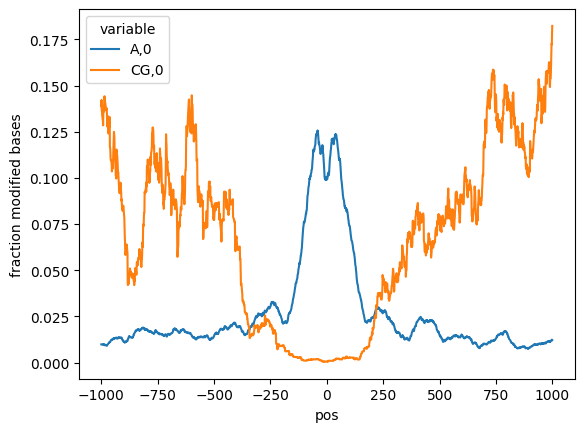

In [17]:
plot_enrichment_profile.by_modification(
    mod_file_name=pileup_file,
    regions=ctcf_target_regions,
    window_size=1000,
    motifs=['A,0','CG,0'],
    smooth_window=50
)

<Axes: xlabel='pos', ylabel='fraction modified bases'>

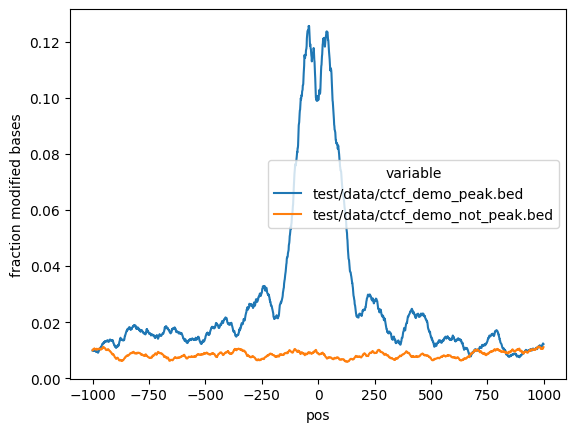

In [18]:
plot_enrichment_profile.by_regions(
    mod_file_name=pileup_file,
    regions_list=[ctcf_target_regions,ctcf_off_target_regions],
    window_size=1000,
    motif='A,0',
    smooth_window=50
)

In [19]:
# plot_enrichment_profile.by_dataset(
#     mod_file_names = [guppy_pileup_chr1,megalodon_pileup_chr1],
#     regions = 'chr1:9000000-10000000',
#     motif = 'CG,0',
#     sample_names = ['guppy basecalling','megalodon basecalling'],
#     window_size = 500000,
# )

## Plot Enrichment

In [20]:
from dimelo import plot_enrichment

<Axes: ylabel='fraction modified bases'>

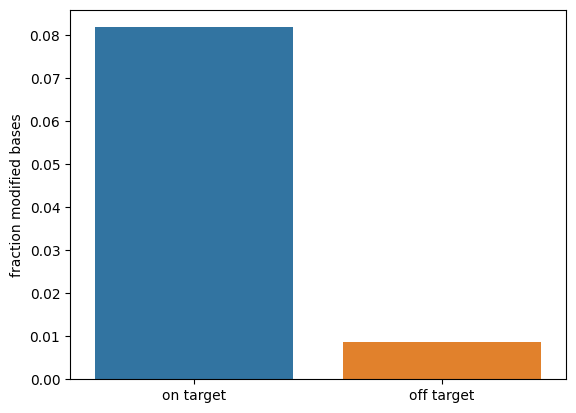

In [21]:
plot_enrichment.by_regions(mod_file_name=pileup_file,
                                regions_list=[ctcf_target_regions, ctcf_off_target_regions],
                                motif='A,0',
                                sample_names=['on target', 'off target'])

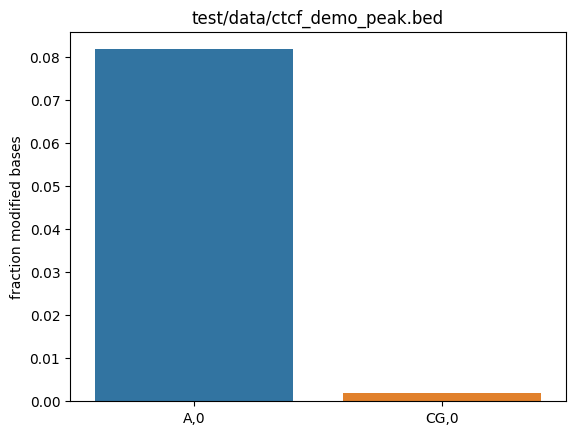

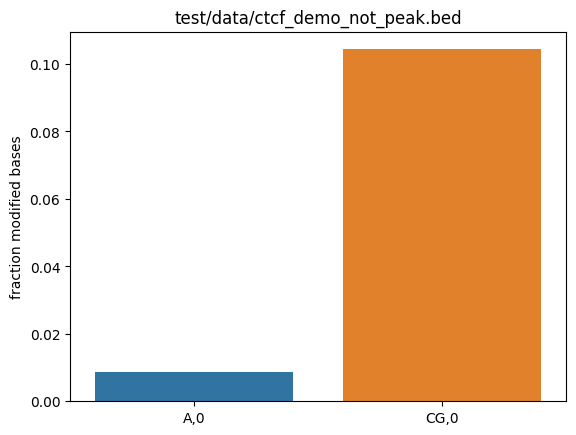

In [22]:
plot_enrichment.by_modification(mod_file_name=pileup_file,
                                regions=ctcf_target_regions,
                                motifs=['A,0','CG,0'],)
plt.title(ctcf_target_regions)
plt.show()
plot_enrichment.by_modification(mod_file_name=pileup_file,
                                regions=ctcf_off_target_regions,
                                motifs=['A,0','CG,0'],)
plt.title(ctcf_off_target_regions)
plt.show()

In [23]:
# plot_enrichment.by_dataset(
#     mod_file_names = [guppy_pileup_chr1,megalodon_pileup_chr1],
#     regions = 'chr1:9000000-10000000',
#     motif = 'CG,0',
#     sample_names = ['guppy basecalling','megalodon basecalling']
# )

## Plot Reads

In [24]:
from dimelo import plot_reads
from pathlib import Path
extract_file = Path('test/output/ctcf_demo_extract/reads.combined_basemods.h5')
# Base input and output directories
test_data_dir = Path('./test/data')
output_dir = Path('./test/output')
ctcf_bam_file = test_data_dir / 'ctcf_demo.sorted.bam'
ctcf_guppy_bam_file = test_data_dir / 'winnowmap_guppy_merge_subset.updated.bam'
ctcf_target_regions = test_data_dir / 'ctcf_demo_peak.bed'
ctcf_off_target_regions = test_data_dir / 'ctcf_demo_not_peak.bed'

<Axes: xlabel='pos', ylabel='read_name'>

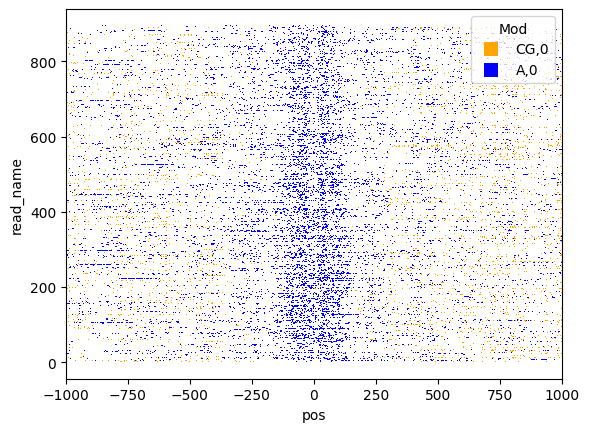

In [25]:
plot_reads.plot_reads(
    mod_file_name=extract_file,
    regions=ctcf_target_regions,
    motifs=['A,0', 'CG,0'],
    window_size=1000,
)

In [26]:
extract_file_no_thresh = parse_bam.extract(
    input_file=ctcf_bam_file_updated,
    output_name='ctcf_demo_extract_no_thresh',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    regions=[ctcf_target_regions,ctcf_off_target_regions],
    motifs=['A,0','CG,0'],
    # thresh=190,
    window_size=1000,
    # cores=None,
    # cleanup=False
)

No specified number of cores requested. 8 available on machine, allocating all.
No valid base modification threshold provided. Raw probs will be saved.
Extracting A,0 sites


> specifying include-only BED outputs only mapped sites
> parsing BED at test/output/ctcf_demo_extract_no_thresh/regions.processed.bed
> processed 300 BED lines
> found BAM index, processing reads in 100000 base pair chunks
> processed 963 reads, 1278404 rows, skipped ~0 reads, failed ~0 reads


Adding A,0 to test/output/ctcf_demo_extract_no_thresh/reads.combined_basemods.h5
963 reads found in test/output/ctcf_demo_extract_no_thresh/reads.A,0.txt
Extracting CG,0 sites


> specifying include-only BED outputs only mapped sites
> parsing BED at test/output/ctcf_demo_extract_no_thresh/regions.processed.bed
> processed 300 BED lines
> found BAM index, processing reads in 100000 base pair chunks
> processed 963 reads, 106327 rows, skipped ~0 reads, failed ~0 reads


Adding CG,0 to test/output/ctcf_demo_extract_no_thresh/reads.combined_basemods.h5
963 reads found in test/output/ctcf_demo_extract_no_thresh/reads.CG,0.txt
extending from 963 to 1926


In [27]:
try:
    plot_reads.plot_reads(
        mod_file_name=extract_file_no_thresh,
        regions=ctcf_target_regions,
        motifs=['A,0', 'CG,0'],
        window_size=1000,
    )
except Exception as e:
    print('This is expected to fail. Read the error message below:\n\n')
    print(e)

This is expected to fail. Read the error message below:


No threshold has been applied to this .h5 single read data. You must provide a threshold using the thresh parameter in order to extract binarized modification arrays.


Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.


<Axes: xlabel='pos', ylabel='read_name'>

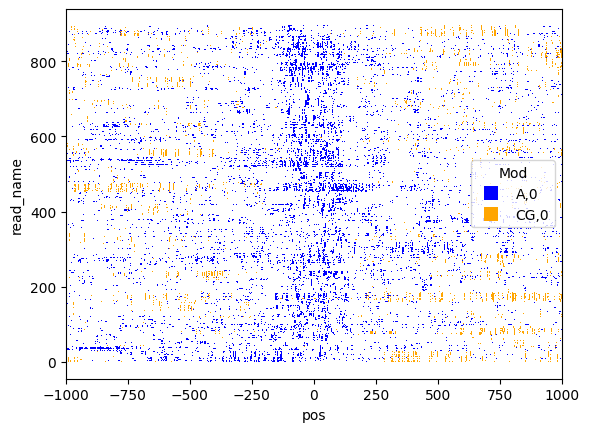

In [28]:
plot_reads.plot_reads(
    mod_file_name=extract_file_no_thresh,
    regions=ctcf_target_regions,
    motifs=['A,0', 'CG,0'],
    window_size=1000,
    thresh=190,
    sort_by=['region_start','strand']
)

# Manually Loading Processed Data

## Load sum total modified/valid base read counts by genomic regions

In [29]:
from dimelo import load_processed

In [30]:
modified_base_count,valid_base_count = load_processed.pileup_counts_from_bedmethyl(
    bedmethyl_file = pileup_file,
    motif = 'A,0',
    regions = ctcf_target_regions
)
print('total methylated adenines across regions in bed file:',modified_base_count,'\ntotal adenine reads called as methylated or unmethylated across regions in bed file:',valid_base_count)

total methylated adenines across regions in bed file: 14242 
total adenine reads called as methylated or unmethylated across regions in bed file: 174078


In [31]:
modified_base_count,valid_base_count = load_processed.pileup_counts_from_bedmethyl(
    bedmethyl_file = pileup_file,
    motif = 'A,0',
    regions = 'chr1:114358436-114358754',
)
print('total methylated adenines in single window:',modified_base_count,'\ntotal adenine reads called as methylated or unmethylated in single window:',valid_base_count)

total methylated adenines in single window: 213 
total adenine reads called as methylated or unmethylated in single window: 1619


## Load modified/valid base read counts by genome alignment position

In [32]:
modified_base_counts,valid_base_counts = load_processed.pileup_vectors_from_bedmethyl(
    bedmethyl_file = pileup_file,
    motif = 'A,0',
    regions = ctcf_target_regions,
    window_size = 10, #You can also not pass window_size, in which case the original bed regions are used BUT must all be the same length
)
print('methylated adenines by position near peak center:\n',modified_base_counts,'\nadenine reads by position, called as methylated or unmethylated:\n',valid_base_counts)

methylated adenines by position near peak center:
 [38 53 32  6  4 54  2 83 90  0 85 39 15 45 11 18 11 16 38 20] 
adenine reads by position, called as methylated or unmethylated:
 [588 679 297 210  70 534  58 445 839   0 891 431  80 486  51 303 286 514
 491 589]


In [33]:
modified_base_counts,valid_base_counts = load_processed.pileup_vectors_from_bedmethyl(
    bedmethyl_file = pileup_file,
    motif = 'A,0',
    regions = 'chr1:114358585-114358605',
    # window_size = 10,
)
print('methylated adenines by position near peak center:\n',modified_base_counts,'\nadenine reads by position, called as methylated or unmethylated:\n',valid_base_counts)

methylated adenines by position near peak center:
 [1 0 3 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0] 
adenine reads by position, called as methylated or unmethylated:
 [14  0 14  0  0 13 14 14 13  0 13  0  0  0  0  0  0  0 13  0]


## Load modified/valid base positions by individual reads

In [34]:
read_data_list, datasets, _ = load_processed.read_vectors_from_hdf5(
    file=extract_file,
    regions=ctcf_target_regions,
    motifs=['CG,0','A,0'],
)
# Print out the data from the first read
for idx,dataset in enumerate(datasets):
    print(dataset)
    for read_data in read_data_list:
        print(read_data[idx])
        break

chromosome
chr1
mod_vector
[False False False ... False False False]
motif
A,0
read_end
9194984
read_name
4cda653a-43bd-4872-9562-b5bffb908fb0
read_start
9141407
strand
+
val_vector
[False False False ... False False  True]
region_start
9169918
region_end
9170236
CG,0_mod_fraction
0.037037037037037035
A,0_mod_fraction
0.011673151750972763


In [35]:
read_data_list, datasets, _ = load_processed.read_vectors_from_hdf5(
    file=extract_file_no_thresh,
    regions=ctcf_target_regions,
    motifs=['CG,0','A,0'],
)
# Print out the data from the first read
for idx,dataset in enumerate(datasets):
    print(dataset)
    for read_data in read_data_list:
        print(read_data[idx])
        break

chromosome
chr1
mod_vector
[0.       0.       0.       ... 0.       0.       0.001953]
motif
A,0
read_end
9194984
read_name
4cda653a-43bd-4872-9562-b5bffb908fb0
read_start
9141407
strand
+
val_vector
[0. 0. 0. ... 0. 0. 1.]
region_start
9169918
region_end
9170236
CG,0_mod_fraction
0.0774
A,0_mod_fraction
0.03592


In [36]:
read_data_list, datasets, _ = load_processed.read_vectors_from_hdf5(
    file=extract_file,
    regions='chr1:114358585-114358605',
    motifs=['A,0'],
)
print(datasets)
# Print out the data from the first read
for idx,dataset in enumerate(datasets):
    print(dataset)
    for read_data in read_data_list:
        print(read_data[idx])
        break

['chromosome', 'mod_vector', 'motif', 'read_end', 'read_name', 'read_start', 'strand', 'val_vector', 'region_start', 'region_end', 'A,0_mod_fraction']
chromosome
chr1
mod_vector
[False False False ... False False False]
motif
A,0
read_end
114371007
read_name
bd15781e-a765-43ba-b641-64cff386435f
read_start
114272757
strand
+
val_vector
[False False False ... False False  True]
region_start
114358585
region_end
114358605
A,0_mod_fraction
0.0
